# Introduction
This is my solution for the Spaceship Titanic Competition. The primary purpose of this project is to study Binary classification. <br>
It is part of my studying of Machine learning through the [IBM Machine Learning Professional Certificate](https://www.coursera.org/professional-certificates/ibm-machine-learning).

## Data description
The data was provided by Kaggle as a Spaceship Titanic Competition. There are two data sets: train and test. Train data set have information about success\unsuccess passengers transportation. 

* PassengerId - A unique Id for each passenger. Each Id takes the form gggg_pp where gggg indicates a group the passenger is travelling with and pp is their number within the group. People in a group are often family members, but not always.
* HomePlanet - The planet the passenger departed from, typically their planet of permanent residence.
* CryoSleep - Indicates whether the passenger elected to be put into suspended animation for the duration of the voyage. Passengers in cryosleep are confined to their cabins.
* Cabin - The cabin number where the passenger is staying. Takes the form deck/num/side, where side can be either P for Port or S for Starboard. Destination - The planet the passenger will be debarking to.
* Age - The age of the passenger.
* VIP - Whether the passenger has paid for special VIP service during the voyage.
* RoomService, FoodCourt, ShoppingMall, Spa, VRDeck - Amount the passenger has billed at each of the Spaceship Titanic's many luxury amenities.
* Name - The first and last names of the passenger.

* Transported - Whether the passenger was transported to another dimension. This is the target, the column you are trying to predict

## Project methodology
1) Fillng missing values
2) Create new fatures
3) Check severla models
4) Submit result

## Important insights I got from this work

At the start of the work, I had an idea of how I could add new features based on data. Also, I planned to fill in the missing values very accuracy. At the end of the work, I found that new features might help in several cases (ex., Logistics regression), but for Boosting model (LGBM and Cat), they can worsen the final result of prediction. I received the best results (Top 9% of submissions on 19/12/2022) in case I reduced the initial amount of features. 

I tried to collect all data in one notebook, but if something goes wrong - you can find the best attempt in the version history. Best score 0.80967 - V47.


# Code
## Libraries

In [1]:
# Core
import numpy as np 
import pandas as pd 
import random

#Viz
import matplotlib.pyplot as plt
import seaborn as sns

# Sklearnю Support libs
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold, GridSearchCV, train_test_split
from sklearn.preprocessing import PowerTransformer
from sklearn.preprocessing import MinMaxScaler, MaxAbsScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from imblearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, classification_report, f1_score, roc_auc_score
from sklearn.metrics import precision_score, recall_score
from sklearn.metrics import roc_curve, precision_recall_curve, confusion_matrix



# Models
from sklearn.linear_model import LogisticRegression
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import VotingClassifier

## Data

In [2]:
df_train = pd.read_csv('../input/spaceship-titanic/train.csv')
df_test = pd.read_csv('../input/spaceship-titanic/test.csv')

In [3]:
print('Train set shape:', df_train.shape)
print('-'*60)
df_train.head()

Train set shape: (8693, 14)
------------------------------------------------------------


,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True


In [4]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8693 entries, 0 to 8692
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   8693 non-null   object 
 1   HomePlanet    8492 non-null   object 
 2   CryoSleep     8476 non-null   object 
 3   Cabin         8494 non-null   object 
 4   Destination   8511 non-null   object 
 5   Age           8514 non-null   float64
 6   VIP           8490 non-null   object 
 7   RoomService   8512 non-null   float64
 8   FoodCourt     8510 non-null   float64
 9   ShoppingMall  8485 non-null   float64
 10  Spa           8510 non-null   float64
 11  VRDeck        8505 non-null   float64
 12  Name          8493 non-null   object 
 13  Transported   8693 non-null   bool   
dtypes: bool(1), float64(6), object(7)
memory usage: 891.5+ KB


In [5]:
print('Test set shape:', df_test.shape)
print('-'*60)
df_test.head()

Test set shape: (4277, 13)
------------------------------------------------------------


,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name
0,0013_01,Earth,True,G/3/S,TRAPPIST-1e,27.0,False,0.0,0.0,0.0,0.0,0.0,Nelly Carsoning
1,0018_01,Earth,False,F/4/S,TRAPPIST-1e,19.0,False,0.0,9.0,0.0,2823.0,0.0,Lerome Peckers
2,0019_01,Europa,True,C/0/S,55 Cancri e,31.0,False,0.0,0.0,0.0,0.0,0.0,Sabih Unhearfus
3,0021_01,Europa,False,C/1/S,TRAPPIST-1e,38.0,False,0.0,6652.0,0.0,181.0,585.0,Meratz Caltilter
4,0023_01,Earth,False,F/5/S,TRAPPIST-1e,20.0,False,10.0,0.0,635.0,0.0,0.0,Brence Harperez


In [6]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4277 entries, 0 to 4276
Data columns (total 13 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   4277 non-null   object 
 1   HomePlanet    4190 non-null   object 
 2   CryoSleep     4184 non-null   object 
 3   Cabin         4177 non-null   object 
 4   Destination   4185 non-null   object 
 5   Age           4186 non-null   float64
 6   VIP           4184 non-null   object 
 7   RoomService   4195 non-null   float64
 8   FoodCourt     4171 non-null   float64
 9   ShoppingMall  4179 non-null   float64
 10  Spa           4176 non-null   float64
 11  VRDeck        4197 non-null   float64
 12  Name          4183 non-null   object 
dtypes: float64(6), object(7)
memory usage: 434.5+ KB


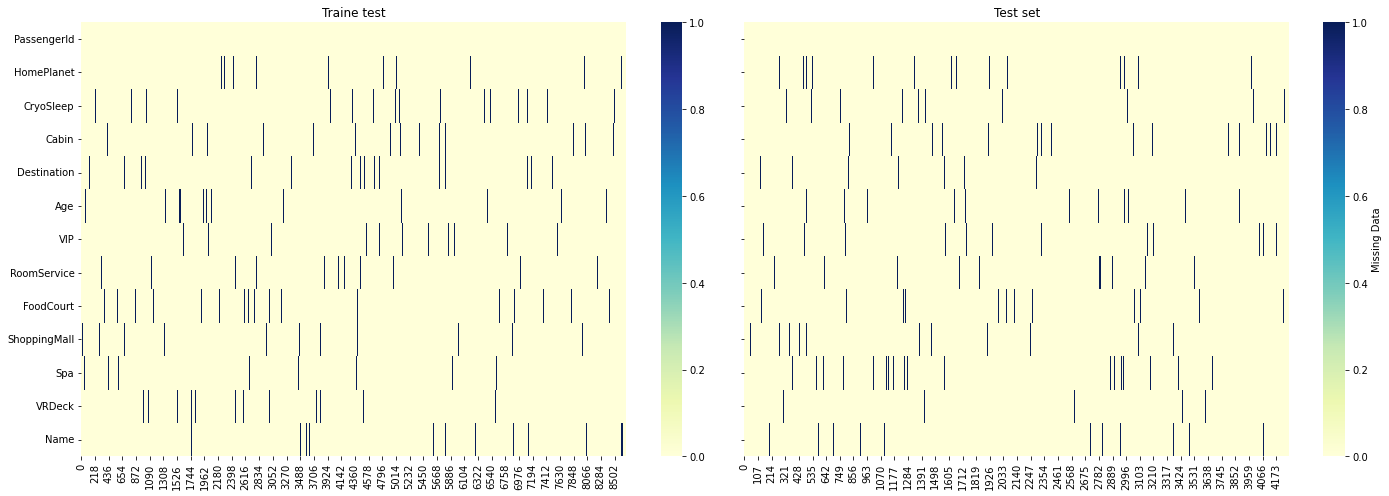

In [7]:
#Viz missing data
fig, ax = plt.subplots(1, 2, sharex = False, sharey = True, figsize = (20, 7))
f1=sns.heatmap(df_train.isna().transpose(),
            cmap = "YlGnBu",
            ax = ax[0]) 
f1.set_title('Traine test')
plt.title('Train set')
f2=sns.heatmap(df_test.isna().transpose(),
            cmap = "YlGnBu",
            cbar_kws = {'label': 'Missing Data'},
            ax = ax[1])
f2.set_title('Test set')
fig.tight_layout()

In [8]:
# Calculate missing data 
percent_missing_train = df_train.isnull().sum() * 100 / len(df_train)
print (f'Missing Values.\n{"-"*60} \n1. Train set:')
for column in df_train.columns:
    print (f'{column} : {df_train[column].isna().sum()} ({percent_missing_train[column].round(2)}%)')
print('-'*60)
percent_missing_test = df_test.isnull().sum() * 100 / len(df_test)
print ('2. Test set:')
for column in df_test.columns:
    print (f'{column} : {df_test[column].isna().sum()} ({percent_missing_test[column].round(2)}%)')

Missing Values.
------------------------------------------------------------ 
1. Train set:
PassengerId : 0 (0.0%)
HomePlanet : 201 (2.31%)
CryoSleep : 217 (2.5%)
Cabin : 199 (2.29%)
Destination : 182 (2.09%)
Age : 179 (2.06%)
VIP : 203 (2.34%)
RoomService : 181 (2.08%)
FoodCourt : 183 (2.11%)
ShoppingMall : 208 (2.39%)
Spa : 183 (2.11%)
VRDeck : 188 (2.16%)
Name : 200 (2.3%)
Transported : 0 (0.0%)
------------------------------------------------------------
2. Test set:
PassengerId : 0 (0.0%)
HomePlanet : 87 (2.03%)
CryoSleep : 93 (2.17%)
Cabin : 100 (2.34%)
Destination : 92 (2.15%)
Age : 91 (2.13%)
VIP : 93 (2.17%)
RoomService : 82 (1.92%)
FoodCourt : 106 (2.48%)
ShoppingMall : 98 (2.29%)
Spa : 101 (2.36%)
VRDeck : 80 (1.87%)
Name : 94 (2.2%)


In [9]:
df_train.nunique()

PassengerId     8693
HomePlanet         3
CryoSleep          2
Cabin           6560
Destination        3
Age               80
VIP                2
RoomService     1273
FoodCourt       1507
ShoppingMall    1115
Spa             1327
VRDeck          1306
Name            8473
Transported        2
dtype: int64

### EDA on both Sets together


e can use merged data set as it is information from one source and for one item (spaceship).

In [10]:
# Save information about Transported and Index
df_train_trans = df_train[['Transported']]

# Merge data sets in one
df_full=df_train.merge(df_test, how = 'outer')

In [11]:
# Function to create Train data set Flag column
def TransportedF (row):
    if row['Transported'] != row['Transported']: # NaN
        return 0
    else:
        return 1 # True\False

# Applying function   
df_full['TransportedF'] = df_full.apply(lambda row: TransportedF(row), axis=1)

# Drop Transported column
df_full = df_full.drop('Transported', axis=1)

In [12]:
#Create new columns
df_full[['Deck','Num','Side']] = df_full['Cabin'].str.split('/',expand=True)
df_full = df_full.drop('Cabin', axis=1)
df_full[['Name','Surname']] = df_full['Name'].str.split(' ', expand=True)
df_full[['PassengerId', 'NGroup']] = df_full['PassengerId'].str.split('_', expand =True)
df_full['AllServices'] = df_full['RoomService'] + df_full['FoodCourt'] + df_full['ShoppingMall'] + df_full['Spa'] + df_full['VRDeck']

In [13]:
# Function to create All Services (the sum of all expenditures for each passenger) Flag column
def empty_services (row):
    if row['AllServices'] != row['AllServices']: # at least one of service is no information
        return 'NaN'
    elif row['AllServices'] == 0.0: # no services
        return 0
    else:
        return 1 # is services
# Applying function   
df_full['AllServicesF'] = df_full.apply(lambda row: empty_services(row), axis=1)

In [14]:
df_full.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12970 entries, 0 to 12969
Data columns (total 20 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   12970 non-null  object 
 1   HomePlanet    12682 non-null  object 
 2   CryoSleep     12660 non-null  object 
 3   Destination   12696 non-null  object 
 4   Age           12700 non-null  float64
 5   VIP           12674 non-null  object 
 6   RoomService   12707 non-null  float64
 7   FoodCourt     12681 non-null  float64
 8   ShoppingMall  12664 non-null  float64
 9   Spa           12686 non-null  float64
 10  VRDeck        12702 non-null  float64
 11  Name          12676 non-null  object 
 12  TransportedF  12970 non-null  int64  
 13  Deck          12671 non-null  object 
 14  Num           12671 non-null  object 
 15  Side          12671 non-null  object 
 16  Surname       12676 non-null  object 
 17  NGroup        12970 non-null  object 
 18  AllServices   11607 non-nu

In [15]:
df_full

,PassengerId,HomePlanet,CryoSleep,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,TransportedF,Deck,Num,Side,Surname,NGroup,AllServices,AllServicesF
0,0001,Europa,False,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham,1,B,0,P,Ofracculy,01,0.0,0
1,0002,Earth,False,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna,1,F,0,S,Vines,01,736.0,1
2,0003,Europa,False,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark,1,A,0,S,Susent,01,10383.0,1
3,0003,Europa,False,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam,1,A,0,S,Susent,02,5176.0,1
4,0004,Earth,False,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy,1,F,1,S,Santantines,01,1091.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12965,9266,Earth,True,TRAPPIST-1e,34.0,False,0.0,0.0,0.0,0.0,0.0,Jeron,0,G,1496,S,Peter,02,0.0,0
12966,9269,Earth,False,TRAPPIST-1e,42.0,False,0.0,847.0,17.0,10.0,144.0,Matty,0,NaN,NaN,NaN,Scheron,01,1018.0,1
12967,9271,Mars,True,55 Cancri e,NaN,False,0.0,0.0,0.0,0.0,0.0,Jayrin,0,D,296,P,Pore,01,0.0,0
12968,9273,Europa,False,NaN,NaN,False,0.0,2680.0,0.0,0.0,523.0,Kitakan,0,D,297,P,Conale,01,3203.0,1


### Filling Missing Values

In [16]:
# Look information. CryoSleep == True. If True then all spenduture we can fill 0. 
df_sleep = df_full.loc[df_full['CryoSleep'] == True]

# Check there are not Allservicesf 1 and cryosleep == true
df_sleep.groupby(['AllServicesF', 'CryoSleep' ])['CryoSleep'].size().unstack()

CryoSleep,True
AllServicesF,
0,4068
NaN,513


In [17]:
# Replace 
columns_services = ('RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck')
for col in columns_services:
    df_full.loc[(df_full[col].isna()) & (df_full['CryoSleep'] == True), col] = 0


# Recalculate with new data
df_full['AllServices'] = df_full['RoomService'] + df_full['FoodCourt'] + df_full['ShoppingMall'] + df_full['Spa'] + df_full['VRDeck']
df_full['AllServicesF'] = df_full.apply(lambda row: empty_services(row), axis=1)

Next step. If there is any spending cryosleep will be false

In [18]:
df_full.loc[(df_full['AllServicesF'] == 1) & (df_full['CryoSleep'].isna()), 'CryoSleep'] = False

In [19]:
percent_missing_full = df_full.isnull().sum() * 100 / len(df_full)
print (f'Missing Values.\n{"-"*60}')
column = 'CryoSleep'
print (f'{column} : {df_full[column].isna().sum()} ({percent_missing_full[column].round(2)}%)')

Missing Values.
------------------------------------------------------------
CryoSleep : 153 (1.18%)


In [20]:
# Update age group feature
df_full.loc[df_full['Age']<=12,'Age_group']='Age_0-12'
df_full.loc[(df_full['Age']>12) & (df_full['Age']<18),'Age_group']='Age_13-17'
df_full.loc[(df_full['Age']>=18) & (df_full['Age']<=25),'Age_group']='Age_18-25'
df_full.loc[(df_full['Age']>25) & (df_full['Age']<=30),'Age_group']='Age_26-30'
df_full.loc[(df_full['Age']>30) & (df_full['Age']<=50),'Age_group']='Age_31-50'
df_full.loc[df_full['Age']>50,'Age_group']='Age_51+'

Text(0.5, 0, 'Age (years)')

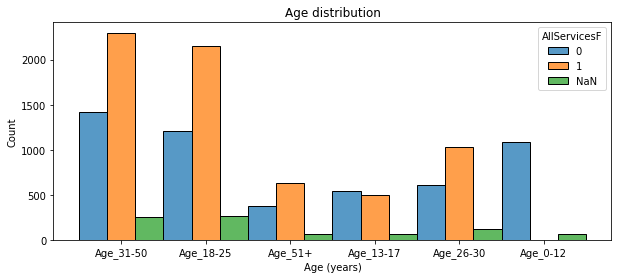

In [21]:
# Figure size
plt.figure(figsize=(10,4))

# Histogram
sns.histplot(data=df_full, x='Age_group', hue='AllServicesF', multiple="dodge")

# Aesthetics
plt.title('Age distribution')
plt.xlabel('Age (years)')

In [22]:
# check there are not allservicesf 1 and cryosleep == true
df_full.groupby(['Age_group', 'CryoSleep', 'AllServicesF' ])['AllServicesF'].size().unstack()

AllServicesF              0       1    NaN
Age_group CryoSleep                       
Age_0-12  False       524.0     NaN   58.0
          True        545.0     NaN    NaN
Age_13-17 False         6.0   501.0   62.0
          True        522.0     NaN    NaN
Age_18-25 False        41.0  2152.0  262.0
          True       1134.0     NaN    NaN
Age_26-30 False        21.0  1034.0  121.0
          True        578.0     NaN    NaN
Age_31-50 False        47.0  2299.0  241.0
          True       1341.0     NaN    NaN
Age_51+   False        15.0   631.0   67.0
          True        347.0     NaN    NaN

There are no bills up to 12 years old. Any expenditure from 13 years.

In [23]:
df_full['AllServicesF'].value_counts()

1      6749
0      5371
NaN     850
Name: AllServicesF, dtype: int64

In [24]:
# replace 
columns_services = ('RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck')
for col in columns_services:
    df_full.loc[(df_full[col].isna()) & (df_full['Age'] <= 12), col] = 0


# recalculate
df_full['AllServices'] = df_full['RoomService'] + df_full['FoodCourt'] + df_full['ShoppingMall'] + df_full['Spa'] + df_full['VRDeck']
df_full['AllServicesF'] = df_full.apply(lambda row: empty_services(row), axis=1)

In [25]:
df_full['AllServicesF'].value_counts()

1      6749
0      5436
NaN     785
Name: AllServicesF, dtype: int64

In [26]:
# Check there are not AllservicesF 1 and CryoSleep == True
df_full.groupby(['Age_group', 'CryoSleep', 'AllServicesF' ])['AllServicesF'].size().unstack()

AllServicesF              0       1    NaN
Age_group CryoSleep                       
Age_0-12  False       582.0     NaN    NaN
          True        545.0     NaN    NaN
Age_13-17 False         6.0   501.0   62.0
          True        522.0     NaN    NaN
Age_18-25 False        41.0  2152.0  262.0
          True       1134.0     NaN    NaN
Age_26-30 False        21.0  1034.0  121.0
          True        578.0     NaN    NaN
Age_31-50 False        47.0  2299.0  241.0
          True       1341.0     NaN    NaN
Age_51+   False        15.0   631.0   67.0
          True        347.0     NaN    NaN

I suppose the best option is to fill NaN by the mean value. It is reasonable in the case of all values except NaN being equal to zero. In other cases, it is just a suppose.
In 27 cases, we have 2 NaNs in one row. It is a tiny amount, and I did not do anything special with them.

In [27]:
# List of interesting columns
columns_services = ['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']
# Create temp columns
df_full['sum_services'] = df_full[columns_services].sum(axis = 1)  # Sum of all services (NaN considered as a 0)
df_full['sum_na'] = df_full[columns_services].apply(lambda row: sum(row.isna()), axis=1) # NaNs number in services
df_full['MeanServices']=df_full['sum_services']/(5 - df_full['sum_na']) # Mean value. It will be not temp column

In [28]:
# Inpute NaN in Services columns by Mean value
for col in columns_services:
    df_full.loc[df_full[col].isna(), col] = df_full['MeanServices']

# Recalculate
df_full['AllServices'] = df_full['RoomService'] + df_full['FoodCourt'] + df_full['ShoppingMall'] + df_full['Spa'] + df_full['VRDeck']
df_full['AllServicesF'] = df_full.apply(lambda row: empty_services(row), axis=1)

#Drop temp columns
df_full=df_full.drop(['sum_services', 'sum_na'], axis=1)

If somebody spent money, they are not in CryoSleep

In [29]:
df_full.loc[(df_full['AllServicesF'] == 1) & (df_full['CryoSleep'] != df_full['CryoSleep']), 'CryoSleep'] = False

At this stage, I have 136 (1.05%) missing values in the column "CryoSleep".
I checked Groups and Cabins, Destination and Home Planet, and Age Groups. There are in one Cabin, or one Group can be a different status of CrySleep. I did not find additional insights. Based on this, I fill in missing values randomly according to the percentage in the total population. 

In [30]:
def replace_na(x):
    """Replace NaN values with values randomly selected from the Series."""
    vc = x.value_counts()
    r = random.choices(vc.keys(), weights=vc.values, k=x.isnull().sum())
    x[x.isnull()] = r
    return x

# reference to the function https://stackoverflow.com/questions/65096532/fill-nan-values-of-dataframe-with-random-values-from-the-column-depending-on-fr?newreg=b7b5cf5033f745caa6bbdbfa9d20feb1

In [31]:
random.seed(43)
df_full['CryoSleep'] = replace_na(df_full['CryoSleep'])

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


VIP filling. There is no VIP status if any of those:
1) Age < 18 
2) Home Planet Earth 
3) Deck G and T 
4) NGroup 6, 7, 8

Other columns have mixed dependances


In [32]:
df_VIP = df_full.loc[(df_full['VIP'] == True)]

<AxesSubplot:xlabel='Age_group', ylabel='Count'>

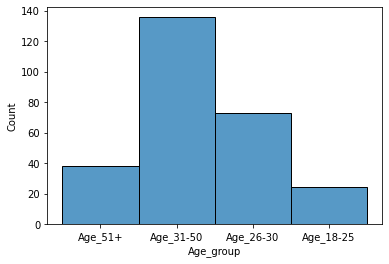

In [33]:
sns.histplot(data=df_VIP, x='Age_group')

<AxesSubplot:xlabel='HomePlanet', ylabel='Count'>

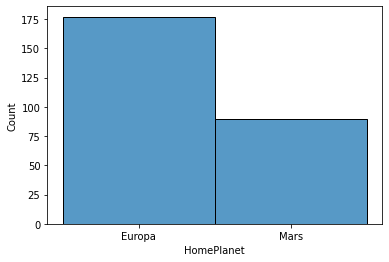

In [34]:
sns.histplot(data=df_VIP, x='HomePlanet')

<AxesSubplot:xlabel='Deck', ylabel='Count'>

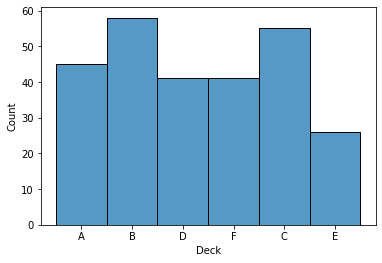

In [35]:
sns.histplot(data=df_VIP, x='Deck')

<AxesSubplot:xlabel='NGroup', ylabel='Count'>

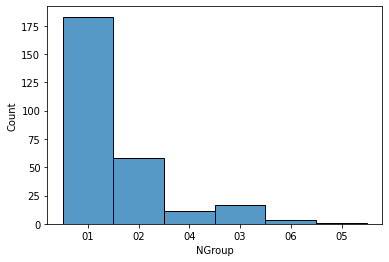

In [36]:
sns.histplot(data=df_VIP, x='NGroup')

In [37]:
# Fillings by insights
df_full['NGroup'] = df_full['NGroup'].astype(int)
df_full.loc[(df_full['VIP'] != df_full['VIP']) & 
            ((df_full['NGroup'] > 5) | (df_full['Deck'] == 'G') | 
            (df_full['Deck'] == 'T') | (df_full['Age'] < 18) | (df_full['HomePlanet'] == 'Earth')), 'VIP'] = False

In [38]:
# Fillings by random based on total population becouse I have no other rulls
df_full['VIP'] = replace_na(df_full['VIP'])

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


Age has correlation with all fetures. In this case I filled missing values by mean value

In [39]:
df_full.loc[(df_full['Age'] != df_full['Age']), 'Age'] = df_full['Age'].mean().round(1)

In [40]:
# Update age group feature
df_full.loc[df_full['Age']<=12,'Age_group']='Age_0-12'
df_full.loc[(df_full['Age']>12) & (df_full['Age']<18),'Age_group']='Age_13-17'
df_full.loc[(df_full['Age']>=18) & (df_full['Age']<=25),'Age_group']='Age_18-25'
df_full.loc[(df_full['Age']>25) & (df_full['Age']<=30),'Age_group']='Age_26-30'
df_full.loc[(df_full['Age']>30) & (df_full['Age']<=50),'Age_group']='Age_31-50'
df_full.loc[df_full['Age']>50,'Age_group']='Age_51+'

Planets (Home and PassengerId)

I got idea how to do this code here https://www.kaggle.com/code/samuelcortinhas/spaceship-titanic-a-complete-guide

In [41]:
HP_gb=df_full.groupby(['PassengerId','HomePlanet'])['HomePlanet'].size().unstack().fillna(0)
for col in HP_gb.columns:
    HP_gb[col] = HP_gb[col].apply(lambda x: x if x<=1 else 1)
HP_gb['x']=HP_gb['Earth']+HP_gb['Europa']+HP_gb['Mars']
HP_gb['x'].nunique()

1

In one PassengerId can be only one Home Planet

In [42]:
# Passengers with missing HomePlanet and in a group with known HomePlanet
HP_index=df_full[df_full['HomePlanet'].isna()][(df_full[df_full['HomePlanet'].isna()]['PassengerId']).isin(HP_gb.index)].index

# Fill corresponding missing values
df_full.loc[HP_index,'HomePlanet']=df_full.iloc[HP_index,:]['PassengerId'].map(lambda x: HP_gb.idxmax(axis=1)[x])

Planets (Home and Deck)

In [43]:
# Joint distribution of Deck and HomePlanet
DHP_gb=df_full.groupby(['Deck','HomePlanet'])['HomePlanet'].size().unstack()
DHP_gb

HomePlanet,Earth,Europa,Mars
Deck,,,
A,NaN,352.0,NaN
B,NaN,1137.0,NaN
C,NaN,1096.0,NaN
D,NaN,301.0,410.0
E,589.0,199.0,515.0
F,2437.0,NaN,1742.0
G,3731.0,NaN,NaN
T,NaN,10.0,NaN


Deck A - only Europa <br>
Deck B - only Europa <br>
Deck C - only Europa <br>
Deck D - Europa and Mars <br>
Deck E - Europa, Mars and Earth<br>
Deck F - Earth and Mars<br>
Deck G - only Earth<br>
Deck T - only Europa<br>


In [44]:
# Replace Home planet based Deck
df_full.loc[(df_full['HomePlanet'] != df_full['HomePlanet']) & 
            ((df_full['Deck'] == 'A') | (df_full['Deck'] == 'T') | 
            (df_full['Deck'] == 'B') | (df_full['Deck'] == 'C')), 'HomePlanet'] = 'Europa'
df_full.loc[(df_full['HomePlanet'] != df_full['HomePlanet']) & (df_full['Deck'] == 'G') , 'HomePlanet'] = 'Earth'

Home Planet and Surname

In [45]:
SHP_gb=df_full.groupby(['Surname','HomePlanet'])['HomePlanet'].size().unstack().fillna(0)
for col in SHP_gb.columns:
    SHP_gb[col] = SHP_gb[col].apply(lambda x: x if x<=1 else 1)
SHP_gb['x']=SHP_gb['Earth']+SHP_gb['Europa']+SHP_gb['Mars']
SHP_gb['x'].nunique()

1

One Surname from one Home Planet

In [46]:
# Passengers with missing HomePlanet and in a group with known HomePlanet
SHP_index=df_full[df_full['HomePlanet'].isna()][(df_full[df_full['HomePlanet'].isna()]['Surname']).isin(SHP_gb.index)].index

# Fill corresponding missing values
df_full.loc[SHP_index,'HomePlanet']=df_full.iloc[SHP_index,:]['Surname'].map(lambda x: SHP_gb.idxmax(axis=1)[x])

Based on Data, we know HomePlanets spread evenly on Deck.


In [47]:
df1=df_full.loc[(df_full['HomePlanet'] != df_full['HomePlanet'])][['Destination', 'Deck']]
df1

,Destination,Deck
2274,TRAPPIST-1e,D
2631,TRAPPIST-1e,F
3091,TRAPPIST-1e,F
4548,TRAPPIST-1e,F
5762,TRAPPIST-1e,F
8969,TRAPPIST-1e,E
10583,TRAPPIST-1e,D
11913,TRAPPIST-1e,E
12551,TRAPPIST-1e,F
12725,TRAPPIST-1e,D


The last 10 missing Home planet have identical destination TRAPPIST-1e. Decks: D, E, F.
It may be any Home Planet.

In [48]:
# Joint distribution of HomePlanet and Destination
HPD_gb=df_full.groupby(['HomePlanet','Destination'])['Destination'].size().unstack()
HPD_gb

Destination,55 Cancri e,PSO J318.5-22,TRAPPIST-1e
HomePlanet,,,
Earth,1000,1085,4778
Europa,1341,29,1769
Mars,300,70,2314


In [49]:
# slice for chossing nedded data
df2=df_full.loc[((df_full['Deck'] == 'D') | (df_full['Deck'] == 'E') | (df_full['Deck'] == 'F')) & (df_full['Destination'] == 'TRAPPIST-1e') ]['HomePlanet']

# Replace by random function with weights
df_full['homeplanet1'] = replace_na(df2) # do it in temp column
df_full['HomePlanet'] = df_full['HomePlanet'].fillna(df_full['homeplanet1'])# filled na from new column. I did id becouse sliesed df before
df_full = df_full.drop('homeplanet1', axis=1) # drop temp column

/opt/conda/lib/python3.7/site-packages/pandas/core/generic.py:8870: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return self._update_inplace(result)


Destinations <br> I did not find any meaningful insight. Missing values were filled by random with weight consideration.

In [50]:
# Replace by random function
df_full['Destination'] = replace_na(df_full['Destination']) 

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


Group and Side

/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


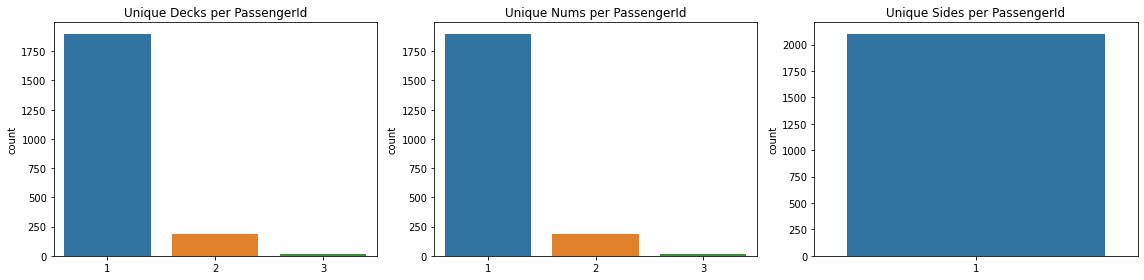

In [51]:
# Joint distribution of PassengerId and Cabin features
GD_gb=df_full[df_full['NGroup']>1].groupby(['PassengerId','Deck'])['Deck'].size().unstack().fillna(0)
GN_gb=df_full[df_full['NGroup']>1].groupby(['PassengerId','Num'])['Num'].size().unstack().fillna(0)
GS_gb=df_full[df_full['NGroup']>1].groupby(['PassengerId','Side'])['Side'].size().unstack().fillna(0)

# Countplots
fig=plt.figure(figsize=(16,4))
plt.subplot(1,3,1)
sns.countplot((GD_gb>0).sum(axis=1))
plt.title('Unique Decks per PassengerId')

plt.subplot(1,3,2)
sns.countplot((GN_gb>0).sum(axis=1))
plt.title('Unique Nums per PassengerId')

plt.subplot(1,3,3)
sns.countplot((GS_gb>0).sum(axis=1))
plt.title('Unique Sides per PassengerId')
fig.tight_layout()

All groups members are at one side

In [52]:
# That should be done for work with all group size. If use >1 group size 2 will not be filled. I dont know why))
GS_gb=df_full[df_full['NGroup']>0].groupby(['PassengerId','Side'])['Side'].size().unstack().fillna(0)

GS_index=df_full[df_full['Side'].isna()][df_full[df_full['Side'].isna()]['PassengerId'].isin(GS_gb.index)].index
df_full.loc[GS_index,'Side']=df_full.iloc[GS_index,:]['PassengerId'].map(lambda x: GS_gb.idxmax(axis=1)[x])

All last 162 NaN in Side also have NaN in Deck and Num

In [53]:
df_full['HomePlanet'][(df_full['Side'] != df_full['Side'])].value_counts()

Earth     101
Mars       32
Europa     29
Name: HomePlanet, dtype: int64

Missing values for Deck were filled randomlly with weights based on Home Planet

In [54]:
# slise fror chossing nedded data
df3=df_full.loc[(df_full['HomePlanet'] == 'Europa')]['Deck']
df4=df_full.loc[(df_full['HomePlanet'] == 'Mars')]['Deck']
df5=df_full.loc[(df_full['HomePlanet'] == 'Earth')]['Deck']

# Replace by random function
df_full['deck1'] = replace_na(df3) # do it in temp column
df_full['Deck'] = df_full['Deck'].fillna(df_full['deck1'][(df_full['HomePlanet'] == 'Europa')])# filled na from new column. I did id becouse sliesed df before
df_full['deck2'] = replace_na(df4) # do it in temp column
df_full['Deck'] = df_full['Deck'].fillna(df_full['deck2'][(df_full['HomePlanet'] == 'Mars')])# filled na from new column. I did id becouse sliesed df before
df_full['deck3'] = replace_na(df5) # do it in temp column
df_full['Deck'] = df_full['Deck'].fillna(df_full['deck3'][(df_full['HomePlanet'] == 'Earth')])# filled na from new column. I did id becouse sliesed df before

# drop temp column
df_full = df_full.drop(columns = {'deck1','deck2', 'deck3'})


/opt/conda/lib/python3.7/site-packages/pandas/core/generic.py:8870: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return self._update_inplace(result)


Last 162 Cabine side I filled randomlly with weights based on othr cabin Side values

In [55]:
df_full['Side'] = replace_na(df_full['Side']) # do it in temp column

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


Num based on PassengerId and Num 

In [56]:
df_full['Num'] = df_full['Num'].astype(float)
df_full['PassengerId'] = df_full['PassengerId'].astype(float)

I got idea how to do this part here https://www.kaggle.com/code/samuelcortinhas/spaceship-titanic-a-complete-guide

Text(0.5, 1.0, 'Num vs PassengerId coloured by Deck')

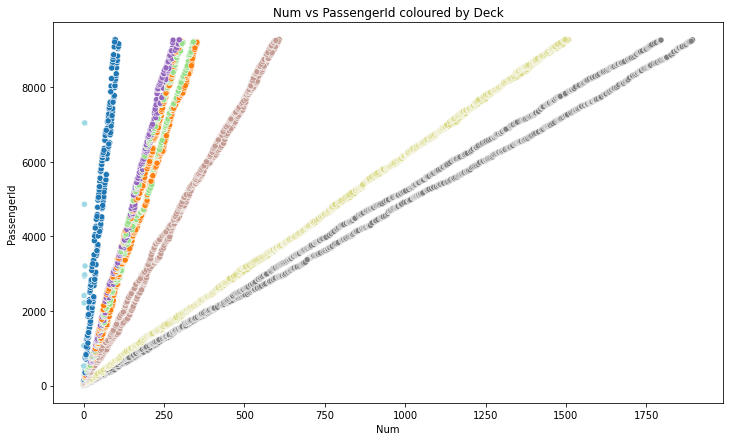

In [57]:
# Scatterplot
plt.figure(figsize=(12,7))
sns.scatterplot(x=df_full['Num'], y=df_full['PassengerId'], c=LabelEncoder().fit_transform(df_full.loc[~df_full['Num'].isna(),'Deck']), cmap='tab20')
plt.title('Num vs PassengerId coloured by Deck')

There is a linear pattern of Num distribution based on PassengerID  on Deck. 

In [58]:
# Extrapolate linear relationship on a deck by deck basis

for side in ['P', 'S']: # I add this loop for bigger accuracy of prediction 
    for deck in ['A', 'B', 'C', 'D', 'E', 'F', 'G']: # There are no missing value on Deck 'T'
        # Features and labels
        X_CN=df_full.loc[~(df_full['Num'].isna()) & (df_full['Deck']==deck) & (df_full['Side']==side),'PassengerId']
        y_CN=df_full.loc[~(df_full['Num'].isna()) & (df_full['Deck']==deck) & (df_full['Side']==side),'Num']
        X_test_CN=df_full.loc[(df_full['Num'].isna()) & (df_full['Deck']==deck) & (df_full['Side']==side),'PassengerId']

        # Linear regression
        model_CN=LinearRegression()
        model_CN.fit(X_CN.values.reshape(-1, 1), y_CN)
        predict_CN=model_CN.predict(X_test_CN.values.reshape(-1, 1))
    
        # Fill missing values with predictions
        df_full.loc[(df_full['Num'].isna()) & (df_full['Deck']==deck) & (df_full['Side']==side),'Num']=predict_CN.astype(int)


In [59]:
percent_missing_full = df_full.isnull().sum() * 100 / len(df_full)
print (f'Missing Values.\n{"-"*60} \nFull set:')
for column in df_full.columns:
    print (f'{column} : {df_full[column].isna().sum()} ({percent_missing_full[column].round(2)}%)')
print ('-'*60)   

Missing Values.
------------------------------------------------------------ 
Full set:
PassengerId : 0 (0.0%)
HomePlanet : 0 (0.0%)
CryoSleep : 0 (0.0%)
Destination : 0 (0.0%)
Age : 0 (0.0%)
VIP : 0 (0.0%)
RoomService : 0 (0.0%)
FoodCourt : 0 (0.0%)
ShoppingMall : 0 (0.0%)
Spa : 0 (0.0%)
VRDeck : 0 (0.0%)
Name : 294 (2.27%)
TransportedF : 0 (0.0%)
Deck : 0 (0.0%)
Num : 1 (0.01%)
Side : 0 (0.0%)
Surname : 294 (2.27%)
NGroup : 0 (0.0%)
AllServices : 0 (0.0%)
AllServicesF : 0 (0.0%)
Age_group : 0 (0.0%)
MeanServices : 0 (0.0%)
------------------------------------------------------------


Now I have 0 missing values

Name and Surname I droped by ethical reason.

In [60]:
df_full = df_full.drop(columns = {'Name', 'Surname'}, axis = 1)

### Preprocessing and Feature Engineering

Probability for passendger to be in any area on the ship. It is assumptiona without solid proofs.Just my ide a how I can increase anouont of usefull data.
Based on spending and CryoSleep.

In [61]:
servises_df = df_full[['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']]
for col in servises_df.columns:
    df_full[col+'%'] = (df_full[col]/df_full['AllServices'])*(2/3) # 8 hours in Cabin at any chances 
df_full['Cabin%'] = (1/3)+df_full['RoomService%'] # Room Service is in the Cabin
df_full = df_full.drop(columns = {'RoomService%'}, axis = 1)
df_full = df_full.fillna(0) # fill NaN after division
df_full.loc[(df_full['CryoSleep'] == 1) | (df_full['AllServicesF'] == 0), 'Cabin%'] = 1

# Add MaxProbabllyLocation column
df_full_MPL = df_full[['Cabin%', 'FoodCourt%', 'ShoppingMall%', 'Spa%', 'VRDeck%']]
df_full['MaxProbabllyLocation'] = df_full_MPL.idxmax(axis=1)
# delet % symbol
df_full['MaxProbabllyLocation'] = df_full['MaxProbabllyLocation'].str.rstrip('%')



Create Solo column

In [62]:
# Function to create Solo column
def solo (row):
    if row['NGroup'] != 1: 
        return 0
    else:
        return 1
df_full['Solo'] = df_full.apply(lambda row: solo(row), axis=1)

In [63]:
# Update age group feature. Rename for unification
df_full.loc[df_full['Age']<=12,'Age_group']='Children'
df_full.loc[(df_full['Age']>12) & (df_full['Age']<18),'Age_group']='Teenager'
df_full.loc[(df_full['Age']>=18) & (df_full['Age']<=25),'Age_group']='YAdult'
df_full.loc[(df_full['Age']>25) & (df_full['Age']<=30),'Age_group']='Adult'
df_full.loc[(df_full['Age']>30) & (df_full['Age']<=50),'Age_group']='MAdult'
df_full.loc[df_full['Age']>50,'Age_group']='SAdult'
df_full = df_full.rename(columns = {'Age_group' : 'AgeG'})

In [64]:
# Create Cabin Num  feature
df_full['NumRegion'] = pd.cut(df_full['Num'], 20, labels=['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19'])

In [65]:
df_full = df_full.replace(True, 1)
df_full = df_full.replace(False, 0)
df_full['NumRegion'] = df_full['NumRegion'].astype(str)
df_full['PassengerId'] = df_full['PassengerId'].astype(int)

In the end I found this part is useless

In [66]:
# Separate data back
train = df_full.loc[df_full['TransportedF'] == 1]
test = df_full.loc[df_full['TransportedF'] == 0]
train = train.drop(columns = {'TransportedF'}, axis = 1)
test = test.drop(columns = {'TransportedF'}, axis = 1)

In [67]:
# Separate features into numerical and categorical
ordinary_cols = ['PassengerId', 'Num', 'FoodCourt%', 'ShoppingMall%', 'Spa%', 'VRDeck%', 'Cabin%']
cat_cols = ['HomePlanet', 'CryoSleep', 'Destination', 'VIP', 'Deck', 'Side', 'NGroup', 'AllServicesF', 'AgeG', 'MaxProbabllyLocation', 'Solo', 'NumRegion']
num_cols = [col for col in list(train.columns) if col not in (cat_cols+ordinary_cols)]

In [68]:
target = df_train_trans.copy()
feature = train.copy()
X = feature
y = target

<AxesSubplot:>

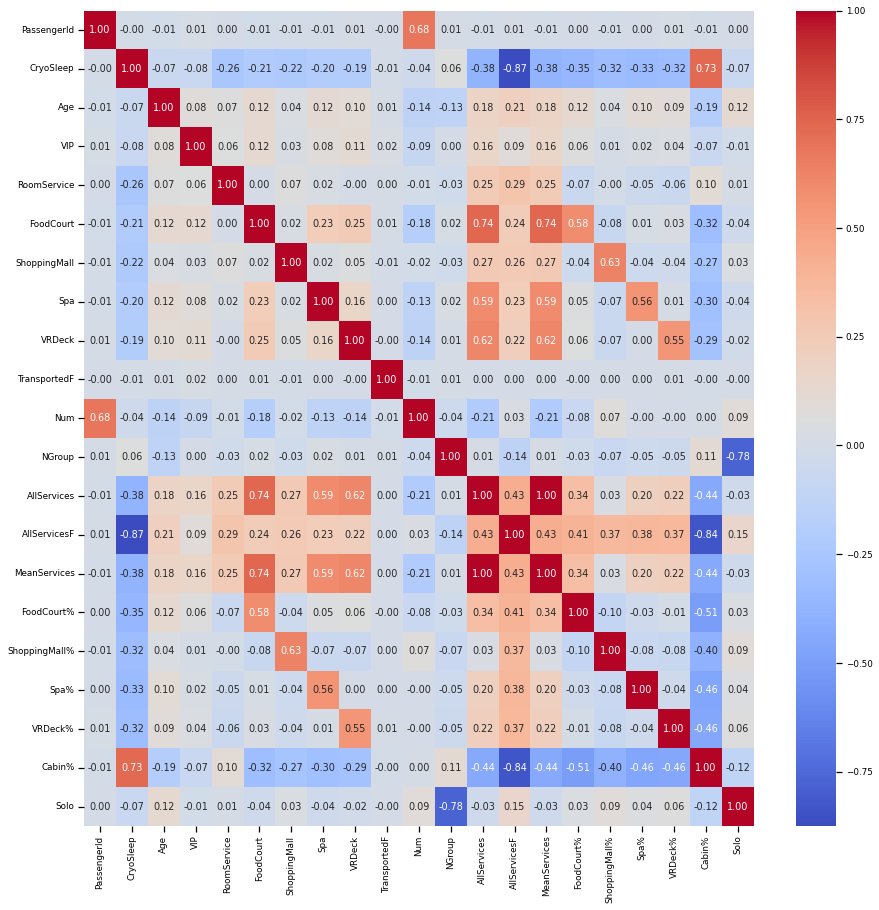

In [69]:
import matplotlib.pyplot as plt
# Heatmap (correlation)
sns.set_context('notebook', font_scale=0.8)
fig, ax = plt.subplots(figsize=(15,15))
sns.heatmap(ax=ax, data=df_full.corr(), annot=True, fmt= '.2f', cmap='coolwarm')

## ML

In [70]:
# calculate skewness scores for numerical features
skewness = X[num_cols].skew(axis=0, numeric_only = True).to_dict()

# define skewness threshold
skewness_threshold = 0.5

# create lists of columns that require normalizing 
skewed_cols = []
for i in skewness:
    if abs(skewness[i]) > skewness_threshold:
        skewed_cols.append(i)

# print results
for i in skewed_cols:
    print(f"Column {i} is skewed: score {round(skewness[i], 2)}")

Column RoomService is skewed: score 6.31
Column FoodCourt is skewed: score 7.17
Column ShoppingMall is skewed: score 12.38
Column Spa is skewed: score 7.67
Column VRDeck is skewed: score 7.89
Column AllServices is skewed: score 4.48
Column MeanServices is skewed: score 4.48


In [71]:
# Split data into train and test sets

# Train-validation split
X_train, X_valid, y_train, y_valid = train_test_split(X,y,stratify=y,train_size=0.8,test_size=0.2,random_state=43)

In [72]:
# Create transformer for preprocessing numerical and categorical features
column_trans = ColumnTransformer([
    ('skewness', PowerTransformer(), skewed_cols),
    ('encoding', OneHotEncoder(drop = 'first', dtype = 'int'), cat_cols)
], remainder = 'passthrough')

In [73]:
# Just cheking
X_train_norm = column_trans.fit_transform(X_train)
X_train_norm.shape

(6954, 66)

In [74]:
# KFold for Grid Search
skf = StratifiedKFold(n_splits = 6)

In [75]:
# Logistic Regression
estimator_lr = Pipeline([("preprocessing", column_trans),
                         ("scaling", MaxAbsScaler ()),
                         ("clasifier", LogisticRegression(class_weight = 'balanced', solver='liblinear'))])

params_lr = {
    'clasifier__penalty': ['l1', 'l2'],
    'clasifier__C': np.geomspace(0.1, 5, 10)
}


In [76]:
# do grid search
grid_lr = GridSearchCV(estimator_lr, params_lr, 
                       scoring = 'f1', 
                       cv = skf, 
                       n_jobs = -1, verbose = True)
grid_lr.fit(X_train, y_train.values.ravel())

Fitting 6 folds for each of 20 candidates, totalling 120 fits


GridSearchCV(cv=StratifiedKFold(n_splits=6, random_state=None, shuffle=False),
             estimator=Pipeline(steps=[('preprocessing',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('skewness',
                                                                         PowerTransformer(),
                                                                         ['RoomService',
                                                                          'FoodCourt',
                                                                          'ShoppingMall',
                                                                          'Spa',
                                                                          'VRDeck',
                                                                          'AllServices',
                                                                          'MeanServ

In [77]:
grid_lr.best_score_, grid_lr.best_params_

(0.7993105614403085, {'clasifier__C': 0.1, 'clasifier__penalty': 'l1'})

In [78]:
# function to plot confusion matrix
def vis_conf_matrix(conf_martix, model_name):
    group_names = ['True Neg', 'False Pos', 'False Neg', 'True Pos']
    group_counts = ["{0:0.0f}".format(value) for value in
                    conf_martix.flatten()]
    group_percentages = ["{0:.2%}".format(value) for value in
                         conf_martix.flatten()/np.sum(conf_martix)]
    labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
              zip(group_names,group_counts,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)

    _, ax = plt.subplots(figsize = (6,6))
    ax = sns.heatmap(conf_martix, annot=labels, fmt = '', 
                     annot_kws = {"size": 20, "weight": "bold"}, cmap = 'Blues')  
    labels = ['False', 'True']
    ax.set_title('Confusion Matrix for {}'.format(model_name), fontsize = 15)
    ax.set_xticklabels(labels, fontsize = 10)
    ax.set_yticklabels(labels, fontsize = 10)
    ax.set_xlabel('Prediction', fontsize = 15)
    ax.set_ylabel('Ground Truth', fontsize = 15)
    
# referenc https://www.kaggle.com/code/dariasvasileva/success-of-a-movie-classification

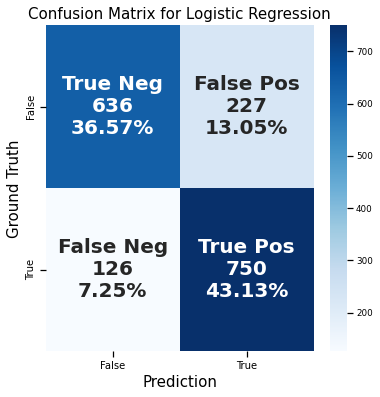

In [79]:
# predict target values
y_pred_lr = grid_lr.predict(X_valid)

# Plot confusion matrix
c_matrix_lr = confusion_matrix(y_valid, y_pred_lr)
vis_conf_matrix(c_matrix_lr, "Logistic Regression")

In [80]:
print(classification_report(y_valid, y_pred_lr))
print('Accuracy score: ', round(accuracy_score(y_valid, y_pred_lr), 2))
print('Precision score: ', round(precision_score(y_valid, y_pred_lr), 2))
print('Recall score: ', round(recall_score(y_valid, y_pred_lr), 2))
print('F1 Score: ', round(f1_score(y_valid, y_pred_lr), 2))

              precision    recall  f1-score   support

       False       0.83      0.74      0.78       863
        True       0.77      0.86      0.81       876

    accuracy                           0.80      1739
   macro avg       0.80      0.80      0.80      1739
weighted avg       0.80      0.80      0.80      1739

Accuracy score:  0.8
Precision score:  0.77
Recall score:  0.86
F1 Score:  0.81


In [81]:
scores = pd.DataFrame(data = {'model': ['logistic regression'],   
                              'f1': [f1_score(y_valid, y_pred_lr)], 
                              'accuracy': [accuracy_score(y_valid, y_pred_lr)],
                              'precision': [precision_score(y_valid, y_pred_lr)],
                              'recall': [recall_score(y_valid, y_pred_lr)]})

scores.loc[scores.model == 'logistic regression', 
           ['tn', 'fp', 'fn', 'tp']] = np.around(c_matrix_lr.ravel()/np.sum(c_matrix_lr)*100, 
                                                 decimals=2)
scores

,model,f1,accuracy,precision,recall,tn,fp,fn,tp
0,logistic regression,0.809498,0.79701,0.767656,0.856164,36.57,13.05,7.25,43.13


In [82]:
# Random Forest Classifier
# I used here only the best parameters because it needs a too long time to show all that I have done. 
estimator_rf = Pipeline([("preprocessing", column_trans),
                         ("scaling", MaxAbsScaler()),
                         ("clasifier", RandomForestClassifier(random_state = 43))])

params_rf = {
             'clasifier__n_estimators': [75, 100, 125], 
             'clasifier__criterion': ['gini'], 
             'clasifier__max_depth': [7, 9, 11],
             'clasifier__max_features': ['sqrt']
}

# do grid search
grid_rf = GridSearchCV(estimator_rf, params_rf, 
                       scoring = 'f1', 
                       cv=skf, 
                       n_jobs = -1, verbose = 1
                      )
grid_rf.fit(X_train, y_train.values.ravel())

Fitting 6 folds for each of 9 candidates, totalling 54 fits


GridSearchCV(cv=StratifiedKFold(n_splits=6, random_state=None, shuffle=False),
             estimator=Pipeline(steps=[('preprocessing',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('skewness',
                                                                         PowerTransformer(),
                                                                         ['RoomService',
                                                                          'FoodCourt',
                                                                          'ShoppingMall',
                                                                          'Spa',
                                                                          'VRDeck',
                                                                          'AllServices',
                                                                          'MeanServ

In [83]:
grid_rf.best_score_, grid_rf.best_params_

(0.8071098830752871,
 {'clasifier__criterion': 'gini',
  'clasifier__max_depth': 9,
  'clasifier__max_features': 'sqrt',
  'clasifier__n_estimators': 100})

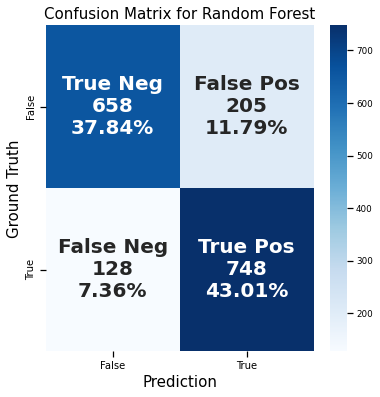

In [84]:
# predict target values
y_pred_rf = grid_rf.predict(X_valid)

# Plot confusion matrix
c_matrix_rf = confusion_matrix(y_valid, y_pred_rf)
vis_conf_matrix(c_matrix_rf, "Random Forest")

In [85]:
print(classification_report(y_valid, y_pred_rf))
print('Accuracy score: ', round(accuracy_score(y_valid, y_pred_rf), 2))
print('Precision score: ', round(precision_score(y_valid, y_pred_rf), 2))
print('Recall score: ', round(recall_score(y_valid, y_pred_rf), 2))
print('F1 Score: ', round(f1_score(y_valid, y_pred_rf), 2))

              precision    recall  f1-score   support

       False       0.84      0.76      0.80       863
        True       0.78      0.85      0.82       876

    accuracy                           0.81      1739
   macro avg       0.81      0.81      0.81      1739
weighted avg       0.81      0.81      0.81      1739

Accuracy score:  0.81
Precision score:  0.78
Recall score:  0.85
F1 Score:  0.82


In [86]:
scores = scores.append({'model': 'random forest',   
                        'f1': f1_score(y_valid, y_pred_rf),
                        'accuracy': accuracy_score(y_valid, y_pred_rf),
                        'precision': precision_score(y_valid, y_pred_rf),
                        'recall': recall_score(y_valid, y_pred_rf)}, 
                        ignore_index=True)

scores.loc[scores.model == 'random forest', 
           ['tn', 'fp', 'fn', 'tp']] = np.around(c_matrix_rf.ravel()/np.sum(c_matrix_rf)*100, 
                                                 decimals=2)
scores

,model,f1,accuracy,precision,recall,tn,fp,fn,tp
0,logistic regression,0.809498,0.797010,0.767656,0.856164,36.57,13.05,7.25,43.13
1,random forest,0.817933,0.808511,0.784890,0.853881,37.84,11.79,7.36,43.01


In [87]:
# K-Nearest Neighbors
estimator_knn = Pipeline([("preprocessing", column_trans),
                          ("scaling", MaxAbsScaler()),
                          ("clasifier", KNeighborsClassifier())])

params_knn = {
    'clasifier__n_neighbors': [i for i in range(10, 15)], 
    'clasifier__weights': ['uniform', 'distance'], 
    'clasifier__p': [1, 2]
}

grid_knn = GridSearchCV(estimator_knn, params_knn, 
                       scoring = 'f1', 
                       cv=skf, 
                       n_jobs = -1, verbose = 1)
grid_knn.fit(X_train, y_train.values.ravel())

Fitting 6 folds for each of 20 candidates, totalling 120 fits


GridSearchCV(cv=StratifiedKFold(n_splits=6, random_state=None, shuffle=False),
             estimator=Pipeline(steps=[('preprocessing',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('skewness',
                                                                         PowerTransformer(),
                                                                         ['RoomService',
                                                                          'FoodCourt',
                                                                          'ShoppingMall',
                                                                          'Spa',
                                                                          'VRDeck',
                                                                          'AllServices',
                                                                          'MeanServ

In [88]:
grid_knn.best_score_, grid_knn.best_params_

(0.7868487947382063,
 {'clasifier__n_neighbors': 13,
  'clasifier__p': 1,
  'clasifier__weights': 'uniform'})

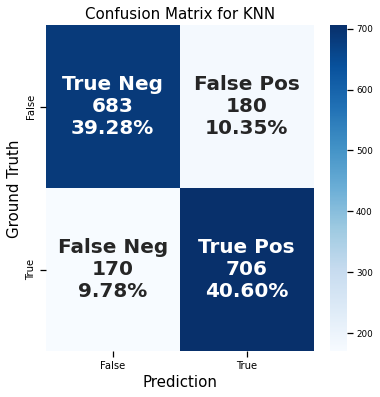

In [89]:
# predict target values
y_pred_knn = grid_knn.predict(X_valid)

# Plot confusion matrix
c_matrix_knn = confusion_matrix(y_valid, y_pred_knn)
vis_conf_matrix(c_matrix_knn, "KNN")

In [90]:
print(classification_report(y_valid, y_pred_knn))
print('Accuracy score: ', round(accuracy_score(y_valid, y_pred_knn), 2))
print('Precision score: ', round(precision_score(y_valid, y_pred_knn), 2))
print('Recall score: ', round(recall_score(y_valid, y_pred_knn), 2))
print('F1 Score: ', round(f1_score(y_valid, y_pred_knn), 2))

              precision    recall  f1-score   support

       False       0.80      0.79      0.80       863
        True       0.80      0.81      0.80       876

    accuracy                           0.80      1739
   macro avg       0.80      0.80      0.80      1739
weighted avg       0.80      0.80      0.80      1739

Accuracy score:  0.8
Precision score:  0.8
Recall score:  0.81
F1 Score:  0.8


In [91]:
scores = scores.append({'model': 'KNN', 
                        'f1': f1_score(y_valid, y_pred_knn),
                        'accuracy': accuracy_score(y_valid, y_pred_knn),
                        'precision': precision_score(y_valid, y_pred_knn),
                        'recall': recall_score(y_valid, y_pred_knn)}, 
                        ignore_index=True)

scores.loc[scores.model == 'KNN', 
           ['tn', 'fp', 'fn', 'tp']] = np.around(c_matrix_knn.ravel()/np.sum(c_matrix_knn)*100, 
                                                 decimals=2)
scores

,model,f1,accuracy,precision,recall,tn,fp,fn,tp
0,logistic regression,0.809498,0.797010,0.767656,0.856164,36.57,13.05,7.25,43.13
1,random forest,0.817933,0.808511,0.784890,0.853881,37.84,11.79,7.36,43.01
2,KNN,0.801362,0.798735,0.796840,0.805936,39.28,10.35,9.78,40.60


In [92]:
# Support Vector Machines
estimator_svc = Pipeline([("preprocessing", column_trans),
                          ("scaling", MaxAbsScaler()),
                          ("clasifier", SVC(kernel = 'rbf', probability = True))])

params_svc = {
              'clasifier__gamma': ['scale'], 
              'clasifier__C': np.geomspace(1, 5, 5)}

grid_svc = GridSearchCV(estimator_svc, params_svc, 
                       scoring = 'f1', 
                       cv=skf, 
                       n_jobs = -1, verbose = 1)
grid_svc.fit(X_train, y_train.values.ravel())

Fitting 6 folds for each of 5 candidates, totalling 30 fits


GridSearchCV(cv=StratifiedKFold(n_splits=6, random_state=None, shuffle=False),
             estimator=Pipeline(steps=[('preprocessing',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('skewness',
                                                                         PowerTransformer(),
                                                                         ['RoomService',
                                                                          'FoodCourt',
                                                                          'ShoppingMall',
                                                                          'Spa',
                                                                          'VRDeck',
                                                                          'AllServices',
                                                                          'MeanServ

In [93]:
grid_svc.best_score_, grid_svc.best_params_

(0.8036761061869423,
 {'clasifier__C': 2.23606797749979, 'clasifier__gamma': 'scale'})

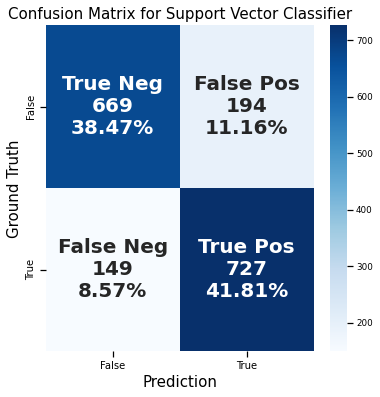

In [94]:
# predict target values
y_pred_svc = grid_svc.predict(X_valid)

# Plot confusion matrix
c_matrix_svc = confusion_matrix(y_valid, y_pred_svc)
vis_conf_matrix(c_matrix_svc, "Support Vector Classifier")

In [95]:
print(classification_report(y_valid, y_pred_svc))
print('Accuracy score: ', round(accuracy_score(y_valid, y_pred_svc), 2))
print('Precision score: ', round(precision_score(y_valid, y_pred_svc), 2))
print('Recall score: ', round(recall_score(y_valid, y_pred_svc), 2))
print('F1 Score: ', round(f1_score(y_valid, y_pred_svc), 2))

              precision    recall  f1-score   support

       False       0.82      0.78      0.80       863
        True       0.79      0.83      0.81       876

    accuracy                           0.80      1739
   macro avg       0.80      0.80      0.80      1739
weighted avg       0.80      0.80      0.80      1739

Accuracy score:  0.8
Precision score:  0.79
Recall score:  0.83
F1 Score:  0.81


In [96]:
scores = scores.append({'model': 'SVC', 
                        'f1': f1_score(y_valid, y_pred_svc),
                        'accuracy': accuracy_score(y_valid, y_pred_svc),
                        'precision': precision_score(y_valid, y_pred_svc),
                        'recall': recall_score(y_valid, y_pred_svc)}, 
                        ignore_index=True)

scores.loc[scores.model == 'SVC', 
           ['tn', 'fp', 'fn', 'tp']] = np.around(c_matrix_svc.ravel()/np.sum(c_matrix_svc)*100, 
                                                 decimals=2)
scores

,model,f1,accuracy,precision,recall,tn,fp,fn,tp
0,logistic regression,0.809498,0.797010,0.767656,0.856164,36.57,13.05,7.25,43.13
1,random forest,0.817933,0.808511,0.784890,0.853881,37.84,11.79,7.36,43.01
2,KNN,0.801362,0.798735,0.796840,0.805936,39.28,10.35,9.78,40.60
3,SVC,0.809126,0.802760,0.789359,0.829909,38.47,11.16,8.57,41.81


In [97]:
# LGBM
# I used here only the best parameters because it needs a too long time to show all that I have done. 
estimator_lgbm = Pipeline([("preprocessing", column_trans),
                          ("scaling", MaxAbsScaler ()),
                          ("clasifier", LGBMClassifier(objective = 'binary'))])

params_lgbm = {
              'clasifier__n_estimators': [1500], 
              'clasifier__max_depth': [7],
              'clasifier__learning_rate': [0.01],
              'clasifier__num_leaves': [10]
}

grid_lgbm = GridSearchCV(estimator_lgbm, params_lgbm, 
                       scoring = 'f1', 
                       cv=skf, 
                       n_jobs = -1, verbose = 1)
grid_lgbm.fit(X_train, y_train.values.ravel())

Fitting 6 folds for each of 1 candidates, totalling 6 fits


GridSearchCV(cv=StratifiedKFold(n_splits=6, random_state=None, shuffle=False),
             estimator=Pipeline(steps=[('preprocessing',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('skewness',
                                                                         PowerTransformer(),
                                                                         ['RoomService',
                                                                          'FoodCourt',
                                                                          'ShoppingMall',
                                                                          'Spa',
                                                                          'VRDeck',
                                                                          'AllServices',
                                                                          'MeanServ

In [98]:
grid_lgbm.best_score_, grid_lgbm.best_params_

(0.8129800925193139,
 {'clasifier__learning_rate': 0.01,
  'clasifier__max_depth': 7,
  'clasifier__n_estimators': 1500,
  'clasifier__num_leaves': 10})

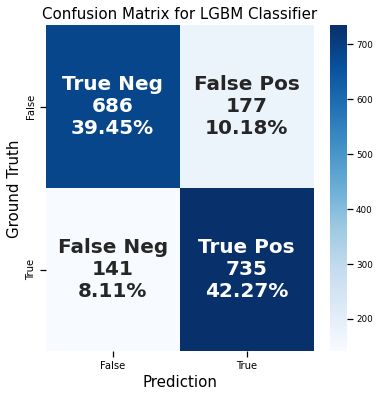

In [99]:
# predict target values
y_pred_lgbm = grid_lgbm.predict(X_valid)

# Plot confusion matrix
c_matrix_lgbm = confusion_matrix(y_valid, y_pred_lgbm)
vis_conf_matrix(c_matrix_lgbm, "LGBM Classifier")

In [100]:
print(classification_report(y_valid, y_pred_lgbm))
print('Accuracy score: ', round(accuracy_score(y_valid, y_pred_lgbm), 2))
print('Precision score: ', round(precision_score(y_valid, y_pred_lgbm), 2))
print('Recall score: ', round(recall_score(y_valid, y_pred_lgbm), 2))
print('F1 Score: ', round(f1_score(y_valid, y_pred_lgbm), 2))

              precision    recall  f1-score   support

       False       0.83      0.79      0.81       863
        True       0.81      0.84      0.82       876

    accuracy                           0.82      1739
   macro avg       0.82      0.82      0.82      1739
weighted avg       0.82      0.82      0.82      1739

Accuracy score:  0.82
Precision score:  0.81
Recall score:  0.84
F1 Score:  0.82


In [101]:
scores = scores.append({'model': 'LGBM', 
                        'f1': f1_score(y_valid, y_pred_lgbm),
                        'accuracy': accuracy_score(y_valid, y_pred_lgbm),
                        'precision': precision_score(y_valid, y_pred_lgbm),
                        'recall': recall_score(y_valid, y_pred_lgbm)}, 
                        ignore_index=True)

scores.loc[scores.model == 'LGBM', 
           ['tn', 'fp', 'fn', 'tp']] = np.around(c_matrix_lgbm.ravel()/np.sum(c_matrix_lgbm)*100, 
                                                 decimals=2)
scores

,model,f1,accuracy,precision,recall,tn,fp,fn,tp
0,logistic regression,0.809498,0.797010,0.767656,0.856164,36.57,13.05,7.25,43.13
1,random forest,0.817933,0.808511,0.784890,0.853881,37.84,11.79,7.36,43.01
2,KNN,0.801362,0.798735,0.796840,0.805936,39.28,10.35,9.78,40.60
3,SVC,0.809126,0.802760,0.789359,0.829909,38.47,11.16,8.57,41.81
4,LGBM,0.822148,0.817136,0.805921,0.839041,39.45,10.18,8.11,42.27


In [102]:
# It is needed for CatBosst model normal working
y_train_cat = y_train.astype(str)

In [103]:
# Cat
# I used here only the best parameters because it needs a too long time to show all that I have done. 
estimator_cat = Pipeline([("preprocessing", column_trans),
                          ("scaling", MaxAbsScaler ()),
                          ("clasifier", CatBoostClassifier(random_state=0, verbose=False))])

params_cat = {
              'clasifier__n_estimators': [2000], 
              'clasifier__max_depth': [5],
              'clasifier__learning_rate': [0.005],
              'clasifier__l2_leaf_reg': [0.01],
}

grid_cat = GridSearchCV(estimator_cat, params_cat, 
                       scoring = 'accuracy', 
                       cv=skf, 
                       n_jobs = -1, #verbose = 1
                        error_score= 'raise',
                        
                        )
grid_cat.fit(X_train, y_train_cat.values.ravel())

GridSearchCV(cv=StratifiedKFold(n_splits=6, random_state=None, shuffle=False),
             error_score='raise',
             estimator=Pipeline(steps=[('preprocessing',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('skewness',
                                                                         PowerTransformer(),
                                                                         ['RoomService',
                                                                          'FoodCourt',
                                                                          'ShoppingMall',
                                                                          'Spa',
                                                                          'VRDeck',
                                                                          'AllServices',
                                                 

In [104]:
grid_cat.best_score_, grid_cat.best_params_

(0.8042853034224907,
 {'clasifier__l2_leaf_reg': 0.01,
  'clasifier__learning_rate': 0.005,
  'clasifier__max_depth': 5,
  'clasifier__n_estimators': 2000})

In [105]:
y_valid_cat = y_valid.astype(str)

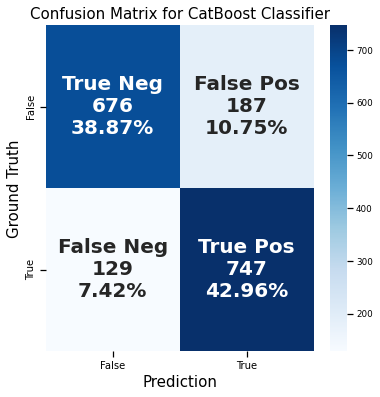

In [106]:
# predict target values
y_pred_cat = grid_cat.predict(X_valid)

# Plot confusion matrix
c_matrix_cat = confusion_matrix(y_valid_cat, y_pred_cat)
vis_conf_matrix(c_matrix_cat, "CatBoost Classifier")

In [107]:
print(classification_report(y_valid_cat, y_pred_cat))
print('Accuracy score: ', round(accuracy_score(y_valid_cat, y_pred_cat), 2))

# I did not use it becouase I have a error pos_label=1 is not a valid label. It should be one of ['False', 'True'] and i dont know how to solv it
print('Precision score: ', round(precision_score(y_valid_cat, y_pred_cat, pos_label = 'True'), 2))
print('Recall score: ', round(recall_score(y_valid_cat, y_pred_cat, pos_label = 'True'), 2))
print('F1 Score: ', round(f1_score(y_valid_cat, y_pred_cat, pos_label = 'True'), 2))

              precision    recall  f1-score   support

       False       0.84      0.78      0.81       863
        True       0.80      0.85      0.83       876

    accuracy                           0.82      1739
   macro avg       0.82      0.82      0.82      1739
weighted avg       0.82      0.82      0.82      1739

Accuracy score:  0.82
Precision score:  0.8
Recall score:  0.85
F1 Score:  0.83


In [108]:
y_valid_cat = y_valid.astype(str)

In [109]:
scores = scores.append({'model': 'CatBoost', 
                        'f1': f1_score(y_valid_cat, y_pred_cat, pos_label = 'True'),
                        'accuracy': accuracy_score(y_valid_cat, y_pred_cat),
                        'precision': precision_score(y_valid_cat, y_pred_cat, pos_label = 'True'),
                        'recall': recall_score(y_valid_cat, y_pred_cat, pos_label = 'True')
                       }, 
                        ignore_index=True
                        )

scores.loc[scores.model == 'CatBoost', 
           ['tn', 'fp', 'fn', 'tp']] = np.around(c_matrix_cat.ravel()/np.sum(c_matrix_cat)*100, 
                                                 decimals=2)
scores

,model,f1,accuracy,precision,recall,tn,fp,fn,tp
0,logistic regression,0.809498,0.797010,0.767656,0.856164,36.57,13.05,7.25,43.13
1,random forest,0.817933,0.808511,0.784890,0.853881,37.84,11.79,7.36,43.01
2,KNN,0.801362,0.798735,0.796840,0.805936,39.28,10.35,9.78,40.60
3,SVC,0.809126,0.802760,0.789359,0.829909,38.47,11.16,8.57,41.81
4,LGBM,0.822148,0.817136,0.805921,0.839041,39.45,10.18,8.11,42.27
5,CatBoost,0.825414,0.818286,0.799786,0.852740,38.87,10.75,7.42,42.96


In [110]:
# Save best classifiers
best_lr = grid_lr.best_estimator_
best_svc = grid_svc.best_estimator_
best_knn = grid_knn.best_estimator_
best_rf = grid_rf.best_estimator_
best_lgbm = grid_lgbm.best_estimator_
best_cat = grid_cat.best_estimator_


# set Voting Classifiers with 'hard' and 'soft' voting
vc_hard = VotingClassifier(estimators = [('lr', best_lr), ('rf', best_rf), ('knn', best_knn), ('svc', best_svc), ('lgbm', best_lgbm), ('cat', best_cat)], voting = 'hard') 
vc_soft = VotingClassifier(estimators = [('lr', best_lr), ('rf', best_rf), ('knn', best_knn), ('svc', best_svc), ('lgbm', best_lgbm), ('cat', best_cat)], voting = 'soft') 

vc_hard = vc_hard.fit(X_train, y_train.values.ravel())
vc_soft = vc_soft.fit(X_train, y_train.values.ravel())

y_pred_vc_hard = vc_hard.predict(X_valid)
y_pred_vc_soft = vc_soft.predict(X_valid)

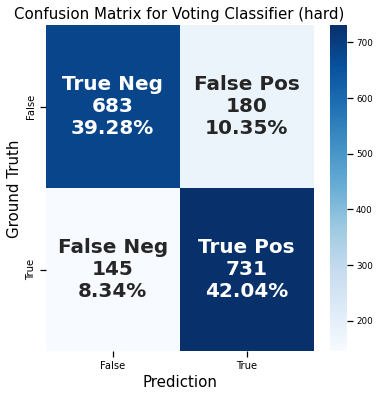

In [111]:
# Plot confusion matrix
c_matrix_vc_hard = confusion_matrix(y_valid, y_pred_vc_hard)
vis_conf_matrix(c_matrix_vc_hard, "Voting Classifier (hard)")

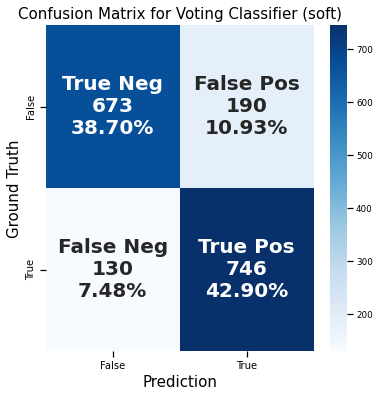

In [112]:
# Plot confusion matrix
c_matrix_vc_soft = confusion_matrix(y_valid, y_pred_vc_soft)
vis_conf_matrix(c_matrix_vc_soft, "Voting Classifier (soft)")

In [113]:
# add scores to the dataframe
scores = scores.append({'model': 'voting hard', 
                        'f1': f1_score(y_valid, y_pred_vc_hard),
                        'accuracy': accuracy_score(y_valid, y_pred_vc_hard),
                        'precision': precision_score(y_valid, y_pred_vc_hard),
                        'recall': recall_score(y_valid, y_pred_vc_hard)},
                        ignore_index=True)

scores = scores.append({'model': 'voting soft',  
                        'f1': f1_score(y_valid, y_pred_vc_soft),
                        'accuracy': accuracy_score(y_valid, y_pred_vc_soft),
                        'precision': precision_score(y_valid, y_pred_vc_soft),
                        'recall': recall_score(y_valid, y_valid)},
                        ignore_index=True)

scores.loc[scores.model == 'voting hard', 
           ['tn', 'fp', 'fn', 'tp']] = np.around(c_matrix_vc_hard.ravel()/np.sum(c_matrix_vc_hard)*100, 
                                                 decimals=2)

scores.loc[scores.model == 'voting soft', 
           ['tn', 'fp', 'fn', 'tp']] = np.around(c_matrix_vc_soft.ravel()/np.sum(c_matrix_vc_soft)*100, 
                                                 decimals=2)

scores

,model,f1,accuracy,precision,recall,tn,fp,fn,tp
0,logistic regression,0.809498,0.797010,0.767656,0.856164,36.57,13.05,7.25,43.13
1,random forest,0.817933,0.808511,0.784890,0.853881,37.84,11.79,7.36,43.01
2,KNN,0.801362,0.798735,0.796840,0.805936,39.28,10.35,9.78,40.60
3,SVC,0.809126,0.802760,0.789359,0.829909,38.47,11.16,8.57,41.81
4,LGBM,0.822148,0.817136,0.805921,0.839041,39.45,10.18,8.11,42.27
5,CatBoost,0.825414,0.818286,0.799786,0.852740,38.87,10.75,7.42,42.96
6,voting hard,0.818131,0.813111,0.802415,0.834475,39.28,10.35,8.34,42.04
7,voting soft,0.823400,0.815986,0.797009,1.000000,38.70,10.93,7.48,42.90


The CatBoost model is the best.

## Best model and Data set

Based on this notebook https://www.kaggle.com/code/costalferz/ds311-project/notebook?scriptVersionId=108541897 I dicided to drop several columns. I choose my best model (CatBoost), train it by new data set and do a submission. 

In [114]:
df_full_best = df_full.drop(columns = {'PassengerId', 'Num', 'HomePlanet', 'Destination','MeanServices', 'MaxProbabllyLocation',
                                  'FoodCourt%', 'ShoppingMall%' , 'Spa%', 'VRDeck%', 'Cabin%', 'NGroup', 'NumRegion', 'Age',
                                  'AllServicesF', 'Solo', 'AgeG','VIP','ShoppingMall'}, axis =1)

In [115]:
cat_cols_best = [ 'CryoSleep', 'Deck', 'Side']

In [116]:
# Separate data back
train_best = df_full_best.loc[df_full_best['TransportedF'] == 1]
test = df_full_best.loc[df_full_best['TransportedF'] == 0]
train_best = train_best.drop(columns = {'TransportedF'}, axis = 1)
test = test.drop(columns = {'TransportedF'}, axis = 1)

In [117]:
target = df_train_trans.copy()
feature_best = train_best.copy()
X_best = feature_best
y = target

In [118]:
# Train-validation split
X_train_best, X_valid_best, y_train_best, y_valid_best = train_test_split(X_best,y,stratify=y,train_size=0.8,test_size=0.2,random_state=43)

In [119]:
column_trans_best = ColumnTransformer([
#     ('skewness', PowerTransformer(), skewed_cols), # I deleted this part from best attempt 
    ('encoding', OneHotEncoder(drop = 'first', dtype = 'int'), cat_cols_best)
], remainder = 'passthrough')

In [120]:
y_train_cat_best = y_train_best.astype(str)

In [121]:
# Cat
estimator_cat_best = Pipeline([("preprocessing", column_trans_best),
                          ("scaling", MinMaxScaler()),
                          ("clasifier", CatBoostClassifier(random_state=0, verbose=False))])

params_cat_best = {
              'clasifier__n_estimators': [2000], 
              'clasifier__max_depth': [5],
              'clasifier__learning_rate': [0.01],
              'clasifier__l2_leaf_reg': [0.005]
}

grid_cat_best = GridSearchCV(estimator_cat_best, params_cat_best, 
                       scoring = 'accuracy', 
                       cv=skf, 
                       n_jobs = -1, #verbose = 1
                       error_score= 'raise',
                       )
grid_cat_best.fit(X_train_best, y_train_cat_best.values.ravel())

GridSearchCV(cv=StratifiedKFold(n_splits=6, random_state=None, shuffle=False),
             error_score='raise',
             estimator=Pipeline(steps=[('preprocessing',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('encoding',
                                                                         OneHotEncoder(drop='first',
                                                                                       dtype='int'),
                                                                         ['CryoSleep',
                                                                          'Deck',
                                                                          'Side'])])),
                                       ('scaling', MinMaxScaler()),
                                       ('clasifier',
                                        <catboost.core.CatBoostClassifier object at

In [122]:
grid_cat_best.best_score_, grid_cat_best.best_params_

(0.8021282714984181,
 {'clasifier__l2_leaf_reg': 0.005,
  'clasifier__learning_rate': 0.01,
  'clasifier__max_depth': 5,
  'clasifier__n_estimators': 2000})

In [123]:
y_valid_cat_best = y_valid_best.astype(str)

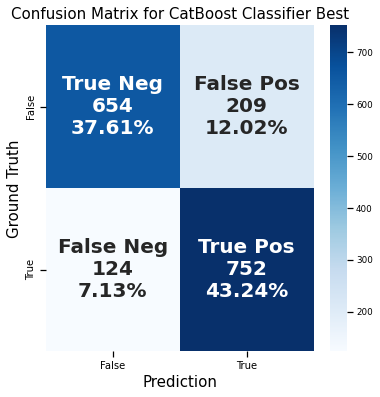

In [124]:
# predict target values
y_pred_cat_best = grid_cat_best.predict(X_valid_best)

# Plot confusion matrix
c_matrix_cat_best = confusion_matrix(y_valid_cat_best, y_pred_cat_best)
vis_conf_matrix(c_matrix_cat_best, "CatBoost Classifier Best")

In [125]:
y_valid_cat_best = y_valid_best.astype(str)

In [126]:
print(classification_report(y_valid_cat_best, y_pred_cat_best))
print('Accuracy score: ', round(accuracy_score(y_valid_cat_best, y_pred_cat_best), 2))

print('Precision score: ', round(precision_score(y_valid_cat_best, y_pred_cat_best, pos_label = 'True'), 2))
print('Recall score: ', round(recall_score(y_valid_cat_best, y_pred_cat_best, pos_label = 'True'), 2))
print('F1 Score: ', round(f1_score(y_valid_cat_best, y_pred_cat_best, pos_label = 'True'), 2))

              precision    recall  f1-score   support

       False       0.84      0.76      0.80       863
        True       0.78      0.86      0.82       876

    accuracy                           0.81      1739
   macro avg       0.81      0.81      0.81      1739
weighted avg       0.81      0.81      0.81      1739

Accuracy score:  0.81
Precision score:  0.78
Recall score:  0.86
F1 Score:  0.82


In [127]:
# Submission
X_best=test.copy()
y_pred_sub = grid_cat_best.predict(X_best)
sub=pd.DataFrame({'Transported':y_pred_sub},index=df_test.index)
df_sub = pd.concat([sub, df_test], axis=1, join="inner")
df_sub_1 = df_sub[['PassengerId', 'Transported']]
df_sub_1.to_csv('submission.csv', index=False)

A possible way to improve the prediction results is a dig dipper in model adjustment. The CatBoost model allows us to adjust many different parameters. Also, It is an option to try to use Boosting model with an additionally adjusted Random Forest model in ensemble modelling. 

<p style="text-align: center; font-weight: 700;"> 
Thank you for reading!<br />
Since I am only at the beginning of my Data Science studying,<br /> 
any kind of feedback (positive or negative) is greatly appreciated.

</p>